In [3]:
# add the main directory to the path
import sys
sys.path.append("..")

import logging
import time
import pandas as pd
import numpy as np
import tqdm
from scipy.optimize import minimize_scalar
import seaborn as sns
import matplotlib.pyplot as plt
from model_no_gams.utils import get_profiles_shares, get_data_by_years

from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm

In [4]:
fn_renewable: str = "../data/renewables_ninja.parquet"
fn_demand: str = "../data/renewables_with_load.parquet"

In [137]:
country = "DE"
year_re = 2019
year_dem = 2019

lst_df = []
for y in range(2015, 2020):
    df = get_profiles_shares(
        country=country,
        year_re=y,
        year_dem=y,
        fn_renewable=fn_renewable,
        fn_demand=fn_demand
    )
    df.index = df.index.map(lambda x: x.replace(year=y))
    lst_df.append(df)
df_shares = pd.concat(lst_df)
df_shares.corr()
df = get_profiles_shares(
    country=country,
    year_re=y,
    year_dem=y,
    fn_renewable=fn_renewable,
    fn_demand=fn_demand
)

In [130]:
df_shares["pv"]

2015-01-01 00:00:00    0.0
2015-01-01 01:00:00    0.0
2015-01-01 02:00:00    0.0
2015-01-01 03:00:00    0.0
2015-01-01 04:00:00    0.0
                      ... 
2019-12-31 19:00:00    0.0
2019-12-31 20:00:00    0.0
2019-12-31 21:00:00    0.0
2019-12-31 22:00:00    0.0
2019-12-31 23:00:00    0.0
Name: pv, Length: 43800, dtype: float64

<Axes: >

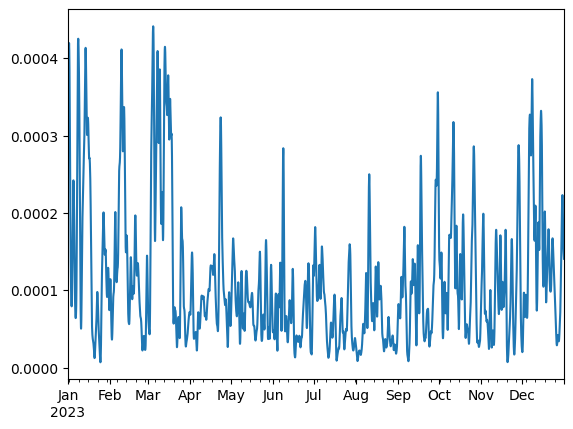

In [150]:
from statsmodels.tsa.seasonal import STL
res = STL(df["wind"], seasonal=25).fit()
res.trend.plot()

In [120]:
df_ = df_shares.assign(
    year=lambda df: df.index.year,
    month=lambda df: df.index.month_name(),
    hour=lambda df: df.index.hour,
    month_hour=lambda df: df.month.astype(str) + "_" + df.hour.astype(str),
    weekday=lambda df: df.index.day_name()
)
dum = ["month", "hour"]
reg = pd.get_dummies(df_[dum], columns=dum, dtype="int", drop_first=True)
sm.OLS(df_shares["wind"]*1000, reg).fit().summary()
#reg

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   wind   R-squared (uncentered):                   0.608
Model:                            OLS   Adj. R-squared (uncentered):              0.608
Method:                 Least Squares   F-statistic:                              2000.
Date:                Thu, 23 May 2024   Prob (F-statistic):                        0.00
Time:                        15:24:29   Log-Likelihood:                          41155.
No. Observations:               43800   AIC:                                 -8.224e+04
Df Residuals:                   43766   BIC:                                 -8.195e+04
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
month_August        0.0010      0.002      0.497      0.619      -0.003       0.005
month_December      0.0996      0.002     49.615      0.000       0.096       0.104
month_February      0.0722      0.002     34.843      0.000       0.068       0.076
month_January       0.1005      0.002     50.056      0.000       0.097       0.104
month_July          0.0082      0.002      4.078      0.000       0.004       0.012
month_June          0.0077      0.002      3.809      0.000       0.004       0.012
month_March         0.0705      0.002     35.115      0.000       0.067       0.074
month_May           0.0220      0.002     10.954      0.000       0.018       0.026
month_November      0.0611      0.002     30.136      0.000       0.057       0.065
month_October       0.0485      0.002     24.151      0.000       0.045       0.052
month_September     0.0264      0.002     12.998      0.000       0.022       0.030
hour_1              0.0690      0.003     27.137      0.000       0.064       0.074
hour_2              0.0674      0.003     26.528      0.000       0.062       0.072
hour_3              0.0652      0.003     25.645      0.000       0.060       0.070
hour_4              0.0610      0.003     23.991      0.000       0.056       0.066
hour_5              0.0569      0.003     22.395      0.000       0.052       0.062
hour_6              0.0562      0.003     22.128      0.000       0.051       0.061
hour_7              0.0592      0.003     23.312      0.000       0.054       0.064
hour_8              0.0642      0.003     25.257      0.000       0.059       0.069
hour_9              0.0691      0.003     27.191      0.000       0.064       0.074
hour_10             0.0734      0.003     28.868      0.000       0.068       0.078
hour_11             0.0763      0.003     30.032      0.000       0.071       0.081
hour_12             0.0772      0.003     30.359      0.000       0.072       0.082
hour_13             0.0761      0.003     29.932      0.000       0.071       0.081
hour_14             0.0743      0.003     29.245      0.000       0.069       0.079
hour_15             0.0739      0.003     29.088      0.000       0.069       0.079
hour_16             0.0740      0.003     29.117      0.000       0.069       0.079
hour_17             0.0752      0.003     29.588      0.000       0.070       0.080
hour_18             0.0779      0.003     30.642      0.000       0.073       0.083
hour_19             0.0801      0.003     31.507      0.000       0.075       0.085
hour_20             0.0796      0.003     31.328      0.000       0.075       0.085
hour_21             0.0781      0.003     30.722      0.000       0.073       0.083
hour_22             0.0761      0.003     29

## Renewable data

In [65]:
df_re = (
    pd.read_parquet(
        fn_renewable,
        filters=[("country", "=", country)],
        columns=["time", "total", "resource"]
    )
    .rename(columns={"time": "dateTime"})
    .pivot_table(index="dateTime", columns="resource", values="total")
    .assign(
        year=lambda x: x.index.year,
        month=lambda x: x.index.month_name(),
        day=lambda x: x.index.day,
        hour=lambda x: x.index.hour,
        weekday=lambda x: x.index.day_name(),
        month_weekday=lambda x: x.month + "_" + x.weekday,
        month_hour=lambda x: x.month + "_" + x.hour.map(str)
    )
)
dummies = (
    pd.get_dummies(df_re["month"], dtype=int)
    #.join(pd.get_dummies(df_re["month_hour"], dtype=int))
)

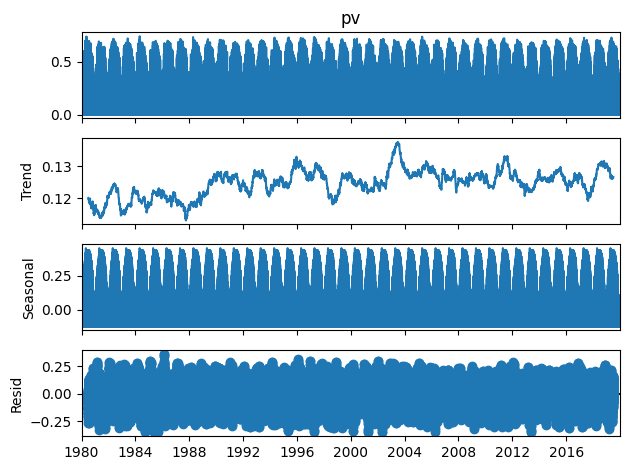

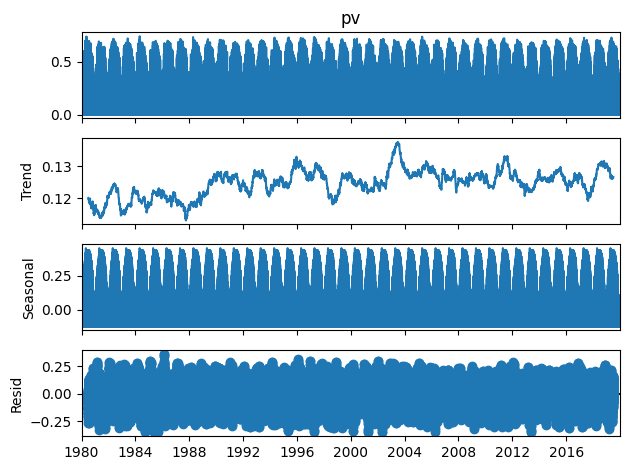

In [124]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df_re.pv, model="additive", period=8760)
res.plot()

In [58]:
sm.OLS(df_re["pv"], dummies).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pv   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     3806.
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        14:53:25   Log-Likelihood:             1.2049e+05
No. Observations:              350640   AIC:                        -2.410e+05
Df Residuals:                  350628   BIC:                        -2.408e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
April          0.1650      0.001    163.151      0.000       0.163       0.167
August         0.1772      0.001    178.137      0.000       0.175       0.179
December       0.0343      0.001     34.476      0.000       0.032       0.036
February       0.0800      0.001     76.802      0.000       0.078       0.082
January        0.0461      0.001     46.352      0.000       0.044       0.048
July           0.1943      0.001    195.317      0.000       0.192       0.196
June           0.1981      0.001    195.916      0.000       0.196       0.200
March          0.1192      0.001    119.831      0.000       0.117       0.121
May            0.1898      0.001    190.824      0.000       0.188       0.192
November       0.0498      0.001     49.297      0.000       0.048       0.052
October        0.0959      0.001     96.366      0.000       0.094       0.098
September      0.1437      0.001    142.063      0.000       0.142       0.146
==============================================================================
Omnibus:                    43870.407   Durbin-Watson:                   0.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62767.798
Skew:                           1.033   Prob(JB):                         0.00
Kurtosis:                       3.159   Cond. No.                         1.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
r